In [142]:
import numpy as np
import pandas as pd
from time import sleep
import math

import matplotlib.pyplot as plt

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.special import gammaln
from scipy.special import psi
from scipy.optimize import fmin_l_bfgs_b as optim
import statsmodels.formula.api as smf
from scipy.stats import nbinom
import statsmodels.api as sm

from scipy.stats import poisson

from scipy.optimize import curve_fit
from scipy.stats import geom

from scipy.stats import gamma
from scipy.integrate import quad
import scipy.integrate as integrate

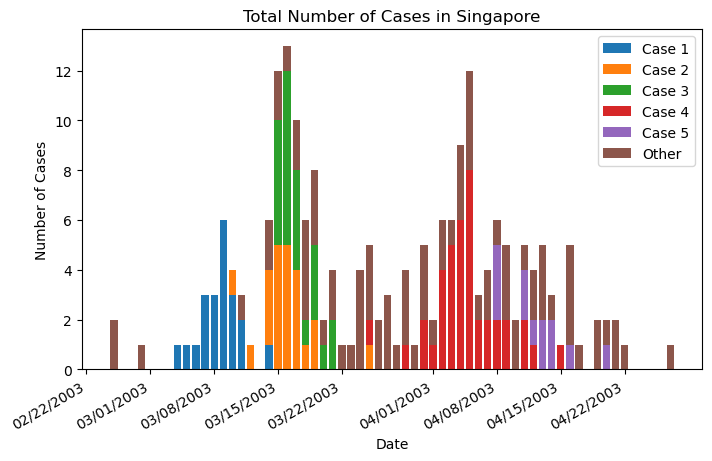

In [143]:
sars_2003 = pd.read_csv("singaporetotalcases.csv")

sars_2003["Total"] = sars_2003["Case 1"] + sars_2003["Case 2"] + sars_2003["Case 3"] + sars_2003["Case 4"] + sars_2003["Case 5"] + sars_2003["Other"]    
sars_2003.head(4)

dates = [dt.datetime.strptime(d, '%m/%d/%Y').date() for d in sars_2003["Date"]]
sars_2003["Date"] = dates
plt.figure(figsize=(8,5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=12) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate() 

plt.bar(sars_2003["Date"], sars_2003["Case 1"], label="Case 1")
plt.bar(sars_2003["Date"], sars_2003["Case 2"], bottom=sars_2003["Case 1"], label="Case 2")
plt.bar(sars_2003["Date"], sars_2003["Case 3"], bottom=sars_2003["Case 1"]+sars_2003["Case 2"], label="Case 3")
plt.bar(sars_2003["Date"], sars_2003["Case 4"], bottom=sars_2003["Case 1"]+sars_2003["Case 2"]+sars_2003["Case 3"], label="Case 4")
plt.bar(sars_2003["Date"], sars_2003["Case 5"], bottom=sars_2003["Case 1"]+sars_2003["Case 2"]+sars_2003["Case 3"]+sars_2003["Case 4"], label="Case 5")
plt.bar(sars_2003["Date"], sars_2003["Other"], bottom=sars_2003["Case 1"]+sars_2003["Case 2"]+sars_2003["Case 3"]+sars_2003["Case 4"]+sars_2003["Case 5"], label="Other")
#plt.gcf().autofmt_xdate()
plt.legend()
plt.title("Total Number of Cases in Singapore")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.savefig('Figure1.png')
plt.show()



In [144]:
first_three_gens = sars_2003.iloc[:57]

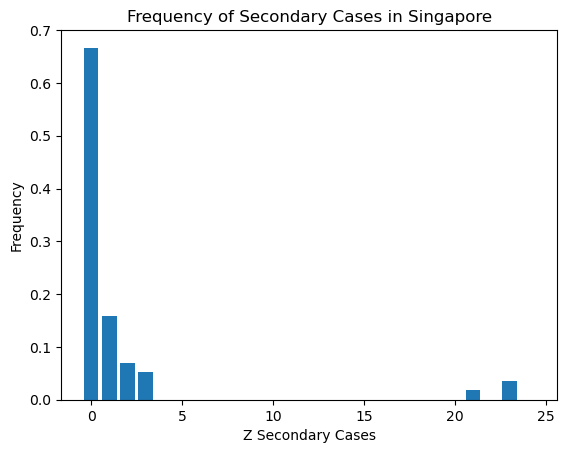

In [145]:
secondary_data = pd.read_csv("singaporethreegenztotal.csv")
secondary_data = secondary_data.iloc[:25]
secondary_data["Proportion"] = secondary_data["Frequency"] / sum(secondary_data["Frequency"])
plt.bar(secondary_data["Z"], secondary_data["Proportion"])
plt.title("Frequency of Secondary Cases in Singapore")
plt.xlabel("Z Secondary Cases")
plt.ylabel("Frequency")
plt.savefig('Figure2.png')
plt.show()

In [146]:
values = []
for i in range(len(secondary_data)):
    if (secondary_data.iloc[i]["Frequency"] != 0):
        values.append(secondary_data.iloc[i]["Frequency"])

R0_estimate = np.sum(secondary_data["Z"] * secondary_data["Frequency"]) / np.sum(secondary_data["Frequency"])

values = []

for i in range(len(secondary_data)):
    for j in range(int(secondary_data.iloc[i]["Frequency"])):
        values.append(secondary_data.iloc[i]["Z"])

# code from https://anton-granik.medium.com/fitting-and-visualizing-a-negative-binomial-distribution-in-python-3cc27fbc7ecf

X = np.ones_like(values)
res = sm.NegativeBinomial(values,X).fit(start_params=[1,1])
mu = np.exp(res.params[0])
p = 1/(1+np.exp(res.params[0])*res.params[1])
k = np.exp(res.params[0])*p/(1-p)

num_zeros = 0

for i in range(len(values)):
    if values[i] == 0:
        num_zeros += 1

print(res.summary())
print("Parameters:", res.params)
print("Mu:", mu)
print("Probability of Success:", p)
print("N:", len(values))
print("k:", k)
print("R0:", R0_estimate)
print("var(Z)/mean(Z)", np.var(values) / np.mean(values))
print("Number of zeros:", num_zeros)

Optimization terminated successfully.
         Current function value: 1.367767
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                   57
Model:               NegativeBinomial   Df Residuals:                       56
Method:                           MLE   Df Model:                            0
Date:                Sun, 05 May 2024   Pseudo R-squ.:               1.903e-11
Time:                        21:43:36   Log-Likelihood:                -77.963
converged:                       True   LL-Null:                       -77.963
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4896      0.350      

In [147]:
poisson_values = poisson.pmf(secondary_data["Z"], R0_estimate)

In [148]:
p = 1 / (1+R0_estimate)
print("Geometric p:", p)
geometric_values = geom.pmf(secondary_data["Z"], p)

Geometric p: 0.37999999999999995


[8.58902820e-01 8.37095100e-02 3.00291535e-02 1.33876070e-02
 6.55142958e-03 3.37721082e-03 1.79974997e-03 9.81496469e-04
 5.44419035e-04 3.05930892e-04 1.73691070e-04 9.94375215e-05
 5.73212646e-05 3.32351381e-05 1.93653102e-05 1.13318836e-05
 6.65568338e-06 3.92194403e-06 2.31775148e-06 1.37326299e-06
 8.15543879e-07 4.85344181e-07 2.89385607e-07 1.72844500e-07
 1.03400340e-07]


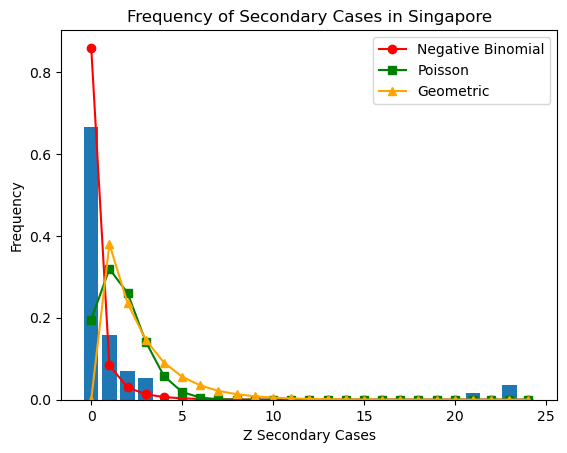

In [149]:
nbin_values = nbinom.pmf(secondary_data["Z"], k, p)
print(nbin_values)
plt.figure(1)
plt.cla()
plt.bar(secondary_data["Z"], secondary_data["Proportion"])
plt.plot(secondary_data["Z"], nbin_values, marker="o", color="red", label="Negative Binomial")
plt.plot(secondary_data["Z"], poisson_values, marker="s", color="green", label="Poisson")
plt.plot(secondary_data["Z"], geometric_values, marker="^", color="orange", label="Geometric")
plt.title("Frequency of Secondary Cases in Singapore")
plt.legend()
plt.xlabel("Z Secondary Cases")
plt.ylabel("Frequency")
plt.show()



In [150]:
reproductive_nums = []

for i in range(11):
    reproductive_nums.append(i)
    
print(reproductive_nums)
p_values = []
for i in range(len(reproductive_nums)):
    p_values.append(1 / (1+reproductive_nums[i]))

nbin_values = nbinom.pmf(0, k, p_values)
print(nbin_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1.         0.89676686 0.84139294 0.8041908  0.77647114 0.75453331
 0.7364694  0.72117166 0.70794208 0.69631359 0.68595898]


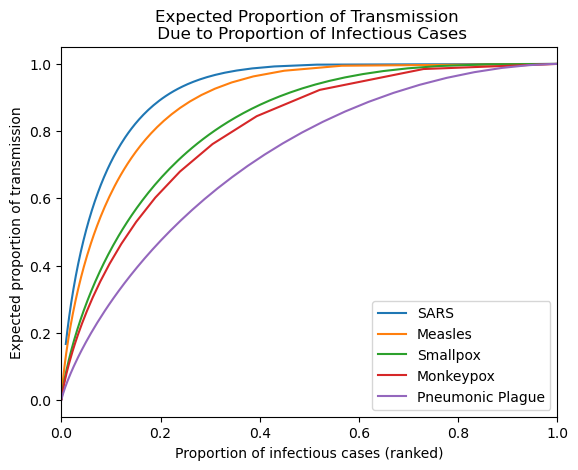

In [151]:
def Prop_Of_Transmission(x_values, k, R0):
    F_v_cdf = gamma.cdf(x_values, k, scale=R0/k)
    F_trans_cdf = []
    for i in range(len(x_values)):
        if i == 0:
            continue
        integrated_value = integrate.quad(lambda x: x * gamma.pdf(x,k,scale=R0/k), 0, x_values[i])[0]
        F_trans_cdf.append((1/R0)*integrated_value)
    return 1-F_v_cdf[1:], 1-np.array(F_trans_cdf)

x_values = np.linspace(-20, 20, 400)  

R0_singapore = np.mean([1.63, 0.94, 1.88])
k_singapore = np.mean([0.16,0.17,0.12])
F_v_cdf_singapore, F_trans_cdf_singapore =  Prop_Of_Transmission(x_values, k_singapore, R0_singapore)
plt.plot(F_v_cdf_singapore, F_trans_cdf_singapore, label="SARS")
                                                                 
R0_measles = np.mean([0.63, 0.82])
k_measles = np.mean([0.23, 0.21])
F_v_cdf_measles, F_trans_cdf_measles =  Prop_Of_Transmission(x_values, k_measles, R0_measles)
plt.plot(F_v_cdf_measles, F_trans_cdf_measles, label="Measles")  

R0_smallpox = np.mean([3.19, 0.8, 1.49])
k_smallpox = np.mean([0.42, 0.29, 0.72])
F_v_cdf_smallpox, F_trans_cdf_smallpox =  Prop_Of_Transmission(x_values, k_smallpox, R0_smallpox)
plt.plot(F_v_cdf_smallpox, F_trans_cdf_smallpox, label="Smallpox") 

R0_monkeypox = 0.32
k_monkeypox = 0.58
F_v_cdf_monkeypox, F_trans_cdf_monkeypox =  Prop_Of_Transmission(x_values, k_monkeypox, R0_monkeypox)
plt.plot(F_v_cdf_monkeypox, F_trans_cdf_monkeypox, label="Monkeypox") 

R0_pneumonic_plague = 1.32
k_pneumonic_plague = 1.37
F_v_cdf_pneumonic_plague, F_trans_cdf_pneumonic_plague =  Prop_Of_Transmission(x_values, k_pneumonic_plague, R0_pneumonic_plague)
plt.plot(F_v_cdf_pneumonic_plague, F_trans_cdf_pneumonic_plague, label="Pneumonic Plague") 
                                                            
plt.xlim([0,1])
plt.title("Expected Proportion of Transmission \n Due to Proportion of Infectious Cases")
plt.legend()
plt.xlabel("Proportion of infectious cases (ranked)")
plt.ylabel("Expected proportion of transmission")
plt.savefig('PropTransmission.png')
plt.show()